In [1]:
# Example of a simple regular expression based NLP chunker.
import nltk
import os
#This ghost file is library for rendering parse tree which you need to install manually
path_to_gs='C:\\Program Files\\gs\\gs9.52\\bin'
os.environ['PATH']+=os.pathsep+path_to_gs

I've used `conll2000` corpus for training chunker.
conll2000 corpus defines the chunks using IOB tags.

It specifies where the chunk begins and end, along with its types.
A POS tagger can be trained on these IOB tags

The chunk tags use the IOB format.
IOB : Inside,Outside,Beginning
B- prefix before a tag indicates ,it's the begining of a chunk
I- prefix indicates that it's inside a chunk
O- tag indicates the token doesn't belong to any chunk


In [3]:
#Here conll2000 corpus for training shallow parser model

nltk.download('conll2000')
from nltk.corpus import conll2000

data= conll2000.chunked_sents()
train_data=data[:10900]
test_data=data[10900:]

print(len(train_data),len(test_data))
print(train_data[1])

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


tree2conlltags,conlltags2tree are chunking utility functions.

`tree2conlltags` , to get triples of (word,tag,chunk tags for each token) This tuples are then finally used to train a tagger. and it learns IOB tags for POS tags.

`conlltags2tree` to generate a parse tree from these token triples
Conlltags2tree() is reversal of tree2conlltags()

We'll be using these functions to train our parser


In [4]:
from nltk.chunk.util import tree2conlltags,conlltags2tree

wtc=tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [5]:
tree=conlltags2tree(wtc)
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [6]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

### What is Tagger?

It reads text and assigns POS tag to each word.(Word,tag)

**Unigram Tagger** : For determining the POS, It only uses a single word.(Single word context-based tagger)

The `UnigramTagger` , `BigramTagger`, and `TrigramTagger` are classes that inherit from the base class `NGramTagger`, which itself inherits from the `ContextTagger` class, which inherits from the `SequentialBackoffTagger` class



We will now define a class `NGramTagChunker` that will take in tagged sentences as training input, get their **(word,POS tag,Chunk tag)WTC triples** nd train a `BigramTagger` with a `UnigramTagger` as the backoff tagger.

We will also define a parse() function to perform shallow parsing on new sentence

In [8]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

#Define the chunker class
class NGramTagChunker(ChunkParserI):
  def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
    train_sent_tags=conll_tag_chunks(train_sentences)
    self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)

  def parse(self,tagged_sentence):
    if not tagged_sentence:
      return None
    pos_tags=[tag for word, tag in tagged_sentence]
    chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
    chunk_tags=[chunk_tag for (pos_tag,chunk_tag) in chunk_pos_tags]
    wpc_tags=[(word,pos_tag,chunk_tag) for ((word,pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
    return conlltags2tree(wpc_tags)

#train chunker model
ntc=NGramTagChunker(train_data)

#evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


Now leverage this model to shallow parse and chunk our sample news article headline.

In [10]:
import pandas as pd
sentence='No new emoji may be released in 2021 due to COVID-19 pandemic word'
nltk_pos_tagged=nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged,columns=['word','POS tag'])

,word,POS tag
0,No,DT
1,new,JJ
2,emoji,NN
3,may,MD
4,be,VB
5,released,VBN
6,in,IN
7,2021,CD
8,due,JJ
9,to,TO


In [11]:
chunk_tree=ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP No/DT new/JJ emoji/NN)
  (VP may/MD be/VB released/VBN)
  (PP in/IN)
  (NP 2021/CD due/JJ)
  (VP to/TO)
  (NP COVID-19/JJ pandemic/JJ word/NN))


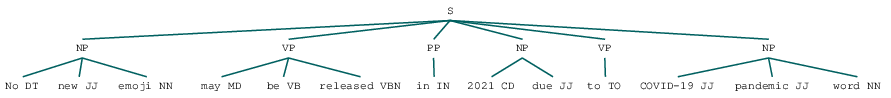

In [12]:
chunk_tree